In [1]:
import os 
import sys 
sys.path.append("../")
import numpy as npn 
import matplotlib.pyplot as plt 
from omegaconf import OmegaConf

In [2]:
results = {}
hub_path = '../data/hub'
for data in os.listdir(hub_path):
    d_path = os.path.join(hub_path, data)
    results[data] = {}
    for model in sorted(os.listdir(d_path)):  
        flags = OmegaConf.load(os.path.join(d_path, model, 'config.yaml'))
        print(f"   | {data:30s} | {model:25s} | {flags.best_perplexity: .3f}")
        results[data][model] = flags 

   | electricity-over-16-25-50      | psb-0-0-also              |  5.085
   | electricity-over-16-25-50      | psb-0-0-only              |  5.168
   | electricity-over-16-25-50      | psb-1-12-also             |  1.002
   | electricity-over-16-25-50      | psb-1-12-only             |  1.035
   | electricity-over-16-25-50      | psb-2-12-also             |  1.001
   | electricity-over-16-25-50      | psb-2-12-only             |  1.026
   | electricity-over-16-25-50      | psb-3-12-also             |  1.001
   | electricity-over-16-25-50      | psb-3-12-only             |  1.020
   | electricity-over-16-25-50      | tsic-0-0-also             |  6.553
   | electricity-over-16-25-50      | tsic-0-0-only             |  6.583
   | electricity-over-16-25-50      | tsic-1-12-also            |  1.075
   | electricity-over-16-25-50      | tsic-1-12-only            |  1.078
   | electricity-over-16-25-50      | tsic-2-12-also            |  1.074
   | electricity-over-16-25-50      | tsic-2-12-onl

## Training Loss 

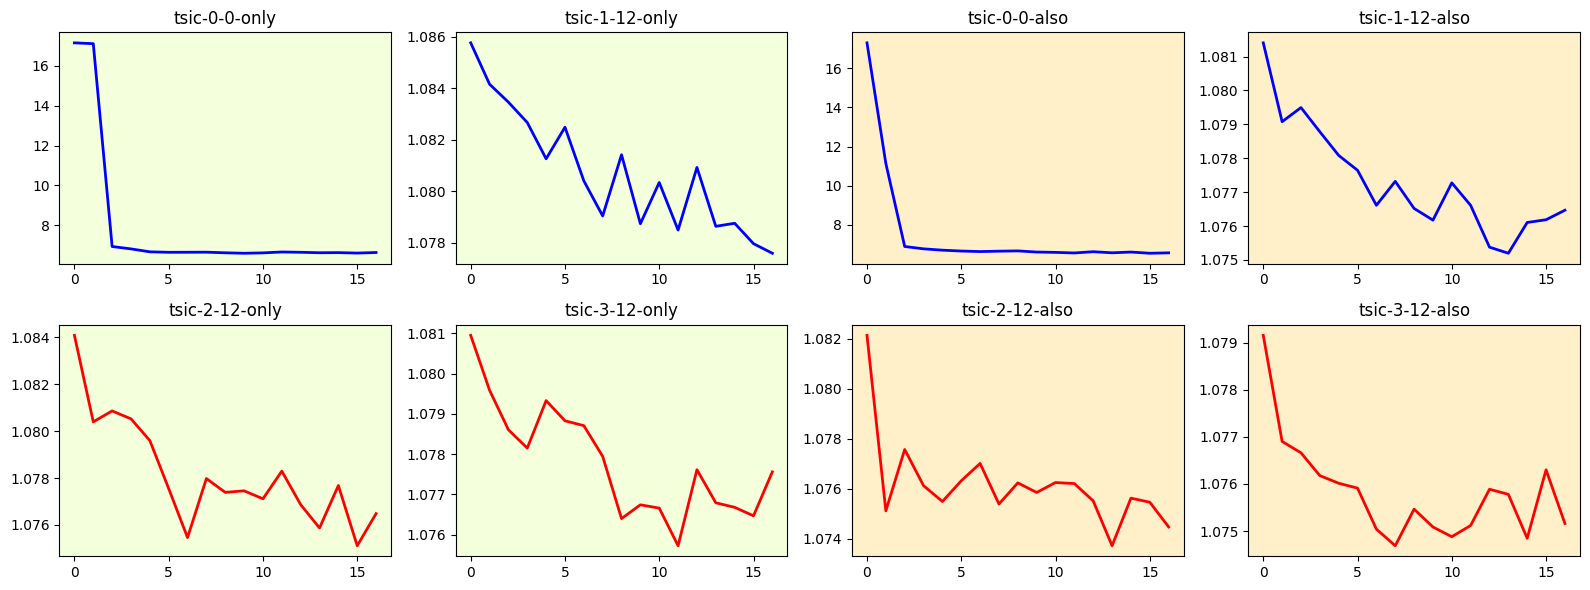

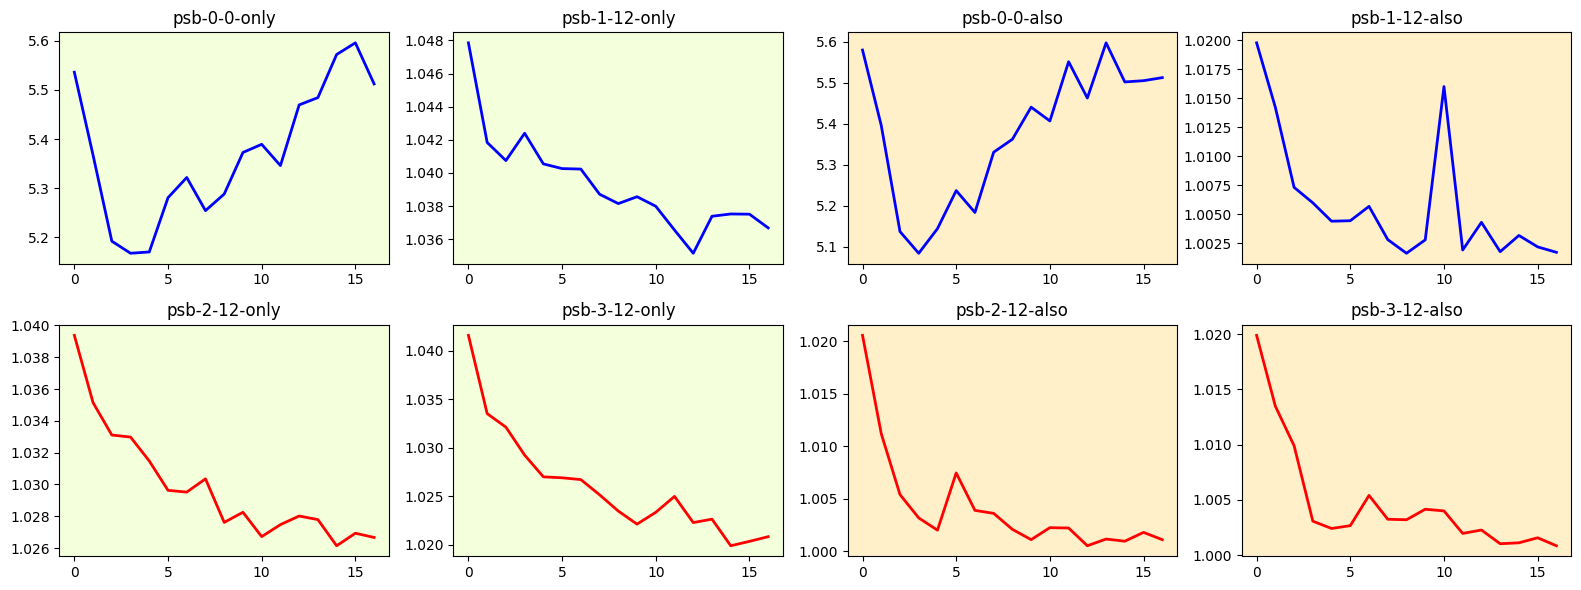

In [4]:
full_models = ['tsic-0-0-only', 'tsic-1-12-only', 'tsic-0-0-also' ,'tsic-1-12-also', 
                  'tsic-2-12-only', 'tsic-3-12-only', 'tsic-2-12-also', 'tsic-3-12-also',
                  'psb-0-0-only', 'psb-1-12-only', 'psb-0-0-also' ,'psb-1-12-also', 
                  'psb-2-12-only', 'psb-3-12-only', 'psb-2-12-also', 'psb-3-12-also',
                  ]

names = ['tsic', 'psb']
for model_name in names:
    for data in results.keys():
        models = [m for m in full_models if model_name in m]
        fig, axes = plt.subplots(2, len(models)//2, figsize=(len(models)*2, 6))
        axes_flat = axes.flat
        
        for model in models:
            flags = results[data][model]
            perplexity = flags.results.perplexity 
            ax = next(axes_flat)
            color = 'blue' if ('0-' in model or '1-' in model) else 'red'
            
            ax.plot(perplexity, c=color, lw=2)
            ax.set_title(model)
            if 'also' in model:
                ax.set_facecolor((255/255, 240/255, 202/255))
            else:
                ax.set_facecolor((244/255,255/255,220/255))
            
            # if int(model.split("-")[1]) == 0:
                # ax.set_ylim([0, 6])
            # else:
            #     ax.set_ylim([5, 7])
                
        plt.tight_layout()

### Tokenwise Loss

['tsic-0-0-only', 'tsic-1-12-only', 'tsic-0-0-also', 'tsic-1-12-also', 'tsic-2-12-only', 'tsic-3-12-only', 'tsic-2-12-also', 'tsic-3-12-also']
['psb-0-0-only', 'psb-1-12-only', 'psb-0-0-also', 'psb-1-12-also', 'psb-2-12-only', 'psb-3-12-only', 'psb-2-12-also', 'psb-3-12-also']


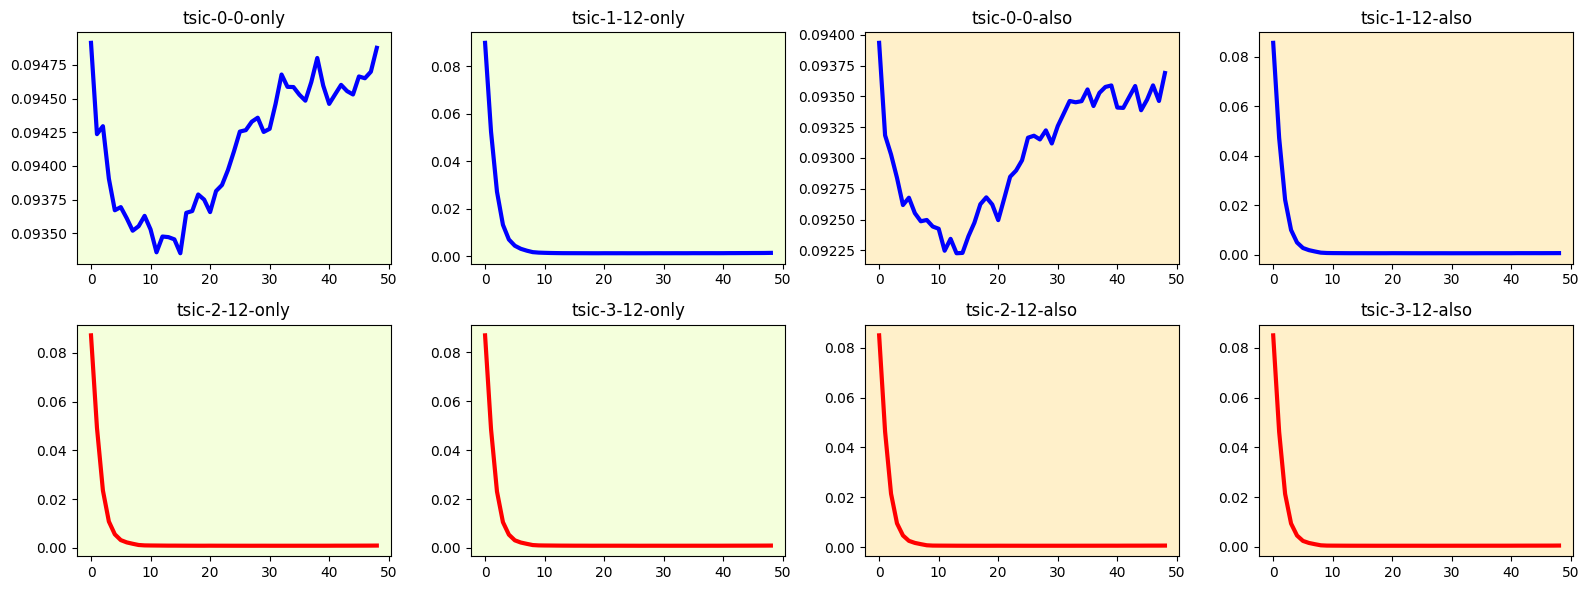

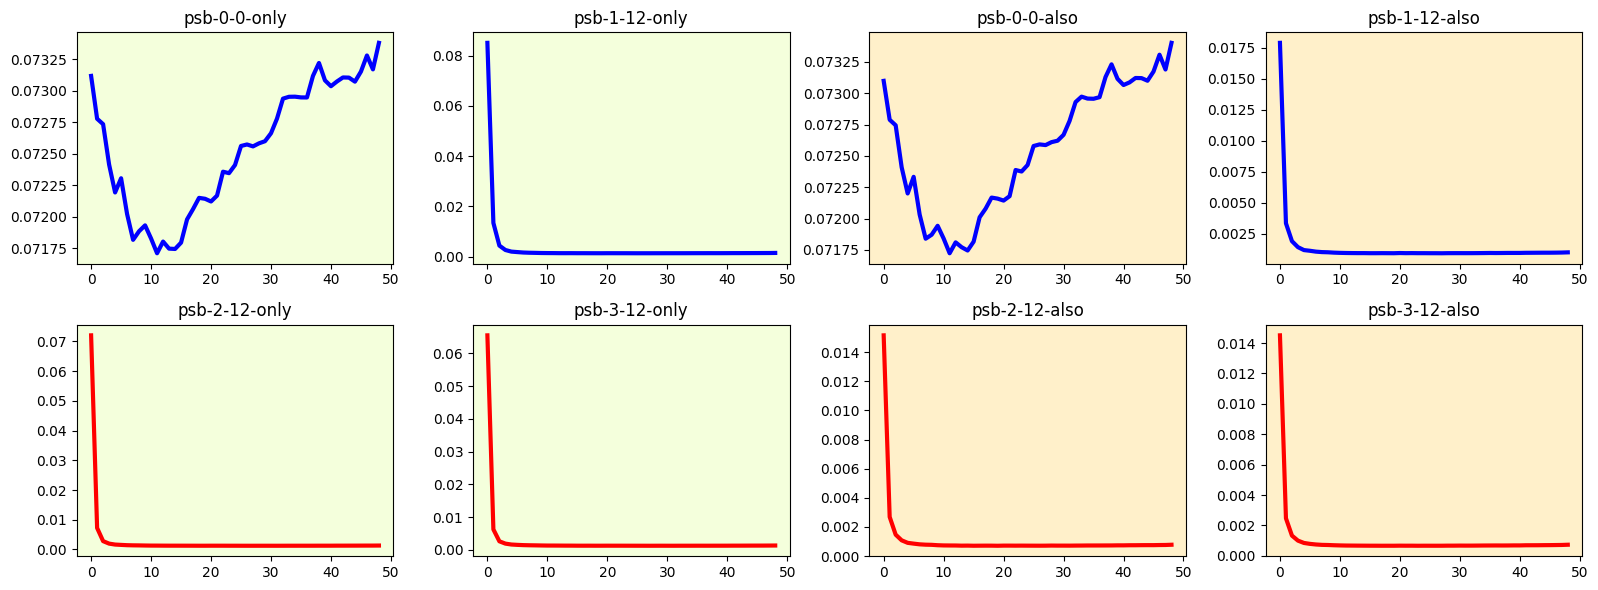

In [5]:
names = ['tsic', 'psb']

for model_name in names:
    for data in results.keys():
        models = [m for m in full_models if model_name in m]
        print(models)
        fig, axes = plt.subplots(2, len(models)//2, figsize=(len(models)*2, 6))
        axes_flat = axes.flat
        for model in models:
            flags = results[data][model]
            token_wise_loss = [t/ flags.num_samples for t in flags.results.token_wise_loss ]
            ax = next(axes_flat)
            color = 'blue' if ('0-' in model or '1-' in model) else 'red'
            
            ax.plot(token_wise_loss, c=color, lw=3)
            ax.set_title(model)
            if 'also' in model:
                ax.set_facecolor((255/255, 240/255, 202/255))
            else:
                ax.set_facecolor((244/255,255/255,220/255))
            
        plt.tight_layout()

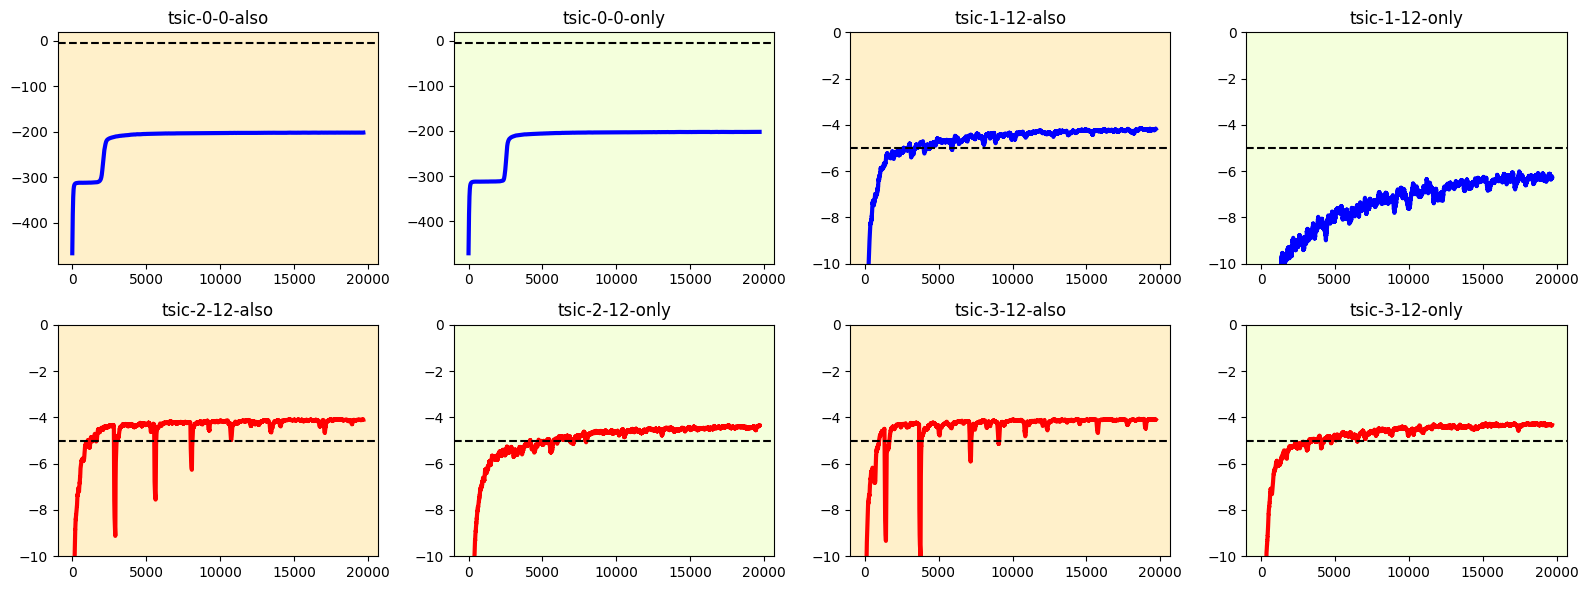

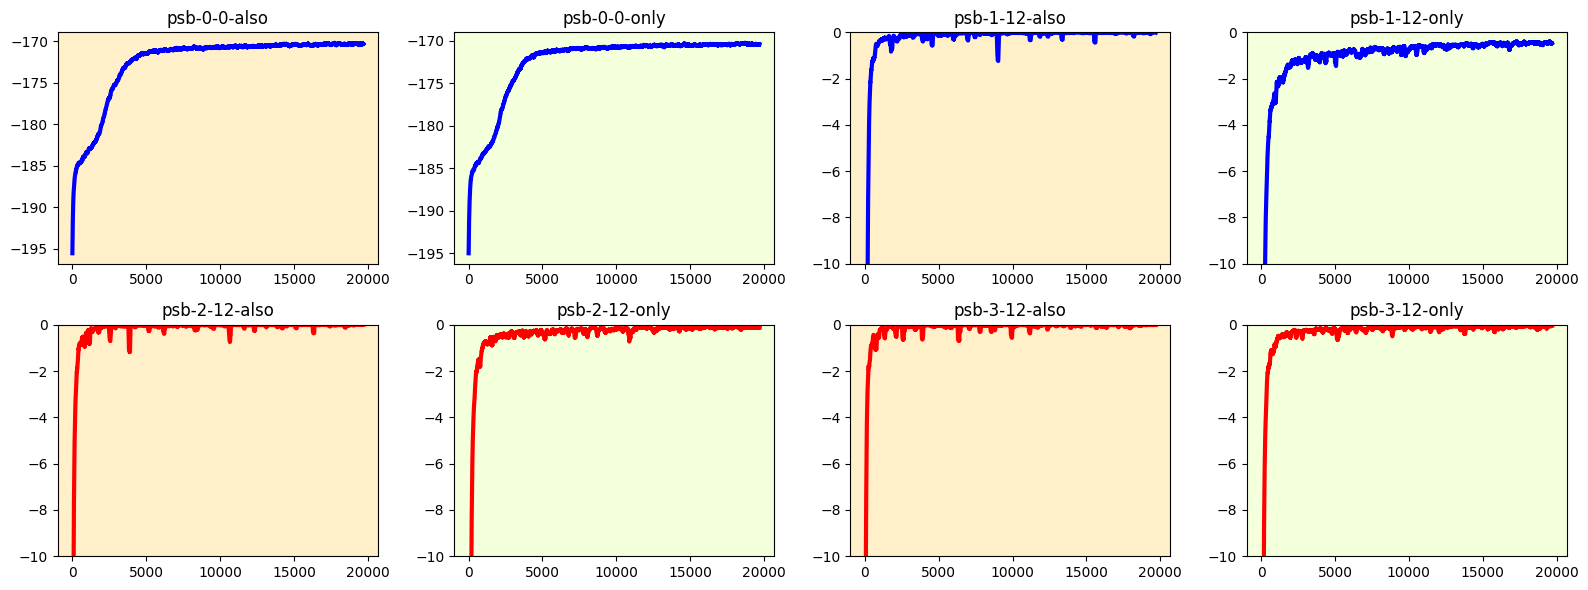

In [6]:
# in context learning score 
import numpy as np 
import seaborn as sns 
import pandas as pd 
names = ['tsic', 'psb']
for model_name in names:
    for data in results.keys():
        models = [m for m in full_models if model_name in m]
        fig, axes = plt.subplots(2, len(models)//2, figsize=(len(models)*2, 6))
        axes_flat = axes.flat
        for model in sorted(models):
            try:
                d_path = os.path.join(hub_path, data)
                token_loss_for_epoch = np.load(os.path.join(d_path, model, 'token_loss_for_epoch.npy'))
                convolve_size=  100
                last = token_loss_for_epoch[convolve_size:, -5]
                early = token_loss_for_epoch[convolve_size:, 5]
                
                # flags = results[data][model]
                # token_wise_loss = [t/ flags.num_samples for t in flags.results.token_wise_loss ]
                ax = next(axes_flat)
                y = last - early
                y = y[y!=0]
                
                y = np.convolve([1/convolve_size for i in range(convolve_size)],y , mode='same')[convolve_size:-convolve_size]
                color = 'blue' if ('0-' in model or '1-' in model) else 'red'
                
                sns.lineplot(y,  c=color, ax=ax, errorbar='sd', lw=3)
                if int(model.split("-")[1]) >0:
                    ax.set_ylim([-10, 0])
                    
                if 'tsic' in model:
                    ax.axhline(-5,  ls='--', c='black',)
                
                ax.set_title(model)
                if 'also' in model:
                    ax.set_facecolor((255/255, 240/255, 202/255))
                else:
                    ax.set_facecolor((244/255,255/255,220/255))
                
            except:
                pass 
        plt.tight_layout()